# Air Quality Foreasting ($CO_2$ emissions) 
## **Business Objective:**
## To forecast $CO_2$ levels for an organization so that the organization can follow government norms with respects to $CO_2$ emission levels.
### Prepare a ppt for each step taken like EDA, Feature Engineering, Model Building,  Model Evaluation and Predicition table, and Deployment. Explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.

## Model Building Phase On Raw data

### Importing the libraries required

In [1]:
# Importing 
# Libraries
import dtale

import warnings
import itertools
%matplotlib inline
import numpy as np
import pandas as pd

from math import sqrt
import seaborn as sns

import missingno as mn
import plotly.io as pio
sns.set_style('darkgrid')

from pandas import Grouper
import scipy.stats as stat
import plotly.express as px
from pandas import DataFrame

import statsmodels.api as smf
import pandas_profiling as pp
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
import plotly.figure_factory as ff

from pandas.plotting import lag_plot
import statsmodels.formula.api as sm
from plotly.offline import plot as off
from plotly.subplots import make_subplots

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.feature_selection import SelectKBest
from pandas_visual_analysis import VisualAnalysis
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES

from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from dataprep.eda import plot, plot_correlation, plot_missing, create_report

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale, RobustScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

In [2]:
data=pd.read_excel('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/CO2 dataset.xlsx'\
                   ,index_col='Year',parse_dates=True)

#data.set_index('Year', inplace=True)
data.index = pd.DatetimeIndex(data.index.values,freq=data.index.inferred_freq)
data.head()

CO2
1800-01-01  0.00568
1801-01-01  0.00561
1802-01-01  0.00555
1803-01-01  0.00548
1804-01-01  0.00542

In [3]:
upsampled_month = data.copy()
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                CO2
1800-01-31  0.00568
1800-02-28      NaN
1800-03-31      NaN
1800-04-30      NaN
1800-05-31      NaN
1800-06-30      NaN
1800-07-31      NaN
1800-08-31      NaN
1800-09-30      NaN
1800-10-31      NaN
1800-11-30      NaN
1800-12-31      NaN
1801-01-31  0.00561


In [4]:
interpolated_month = upsampled_month.interpolate(method='linear') 
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(16,6))
plt.title("Interpolation uisng Linear Method", fontsize =  14)
plt.show()

                 CO2
1800-01-31  0.005680
1800-02-28  0.005674
1800-03-31  0.005668
1800-04-30  0.005662
1800-05-31  0.005657
1800-06-30  0.005651
1800-07-31  0.005645
1800-08-31  0.005639
1800-09-30  0.005633
1800-10-31  0.005628
1800-11-30  0.005622
1800-12-31  0.005616
1801-01-31  0.005610
1801-02-28  0.005605
1801-03-31  0.005600


In [15]:
interpolated_month.duplicated(keep=False).sum()

704

In [32]:
df = interpolated_month[1080:]
df

CO2
1890-01-31   2.530000
1890-02-28   2.553333
1890-03-31   2.576667
1890-04-30   2.600000
1890-05-31   2.623333
...               ...
2013-09-30  14.966667
2013-10-31  15.000000
2013-11-30  15.033333
2013-12-31  15.066667
2014-01-31  15.100000

[1489 rows x 1 columns]

### Splitting Train and Test Data on Original data 

#### Leaving Test Data with 10 Years of Time Series
+ **Training Data** = Fit the model only to training period. 
+ **Testing Data** = Assess the model performance on Testing. 
+ **Deploy model by training on whole dataset. No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.**

In [82]:
test.shape

(49, 1)

In [35]:
train_len = -121
train_data = df[:train_len]
test_data = df[train_len:]

In [39]:
train_data

CO2
1890-01-31   2.530000
1890-02-28   2.553333
1890-03-31   2.576667
1890-04-30   2.600000
1890-05-31   2.623333
...               ...
2003-08-31  17.383333
2003-09-30  17.366667
2003-10-31  17.350000
2003-11-30  17.333333
2003-12-31  17.316667

[1368 rows x 1 columns]

In [37]:
train_data.shape

(1368, 1)

In [41]:
test_data

CO2
2004-01-31  17.300000
2004-02-29  17.300000
2004-03-31  17.300000
2004-04-30  17.300000
2004-05-31  17.300000
...               ...
2013-09-30  14.966667
2013-10-31  15.000000
2013-11-30  15.033333
2013-12-31  15.066667
2014-01-31  15.100000

[121 rows x 1 columns]

In [42]:
test_data.shape

(121, 1)

### We are going to forecast for the last 10 years. that is from 2004 to 2014.

##### Last 121 records contain data from 2004 to 2014 data.

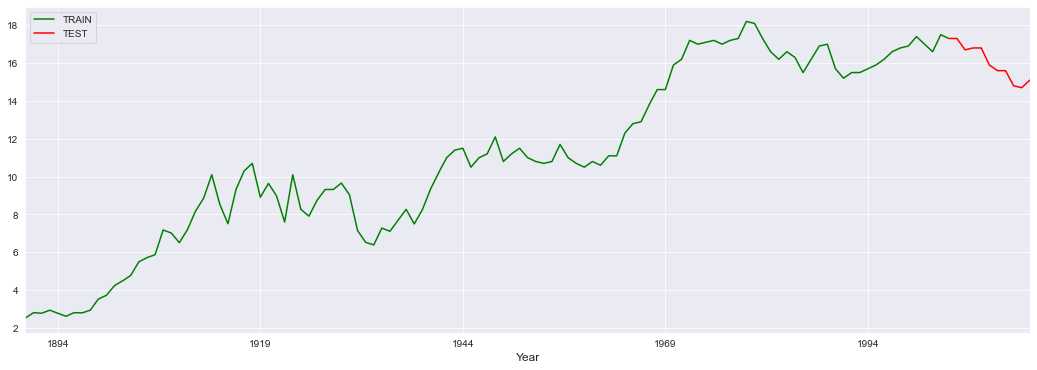

In [43]:
train_data.CO2.plot(legend=True,label='TRAIN',color='green')
test_data.CO2.plot(legend=True,label='TEST', figsize=(18,6),color='red')
plt.xlabel('Year', fontsize= 12)
plt.legend()
plt.show()

In [13]:
%matplotlib inline

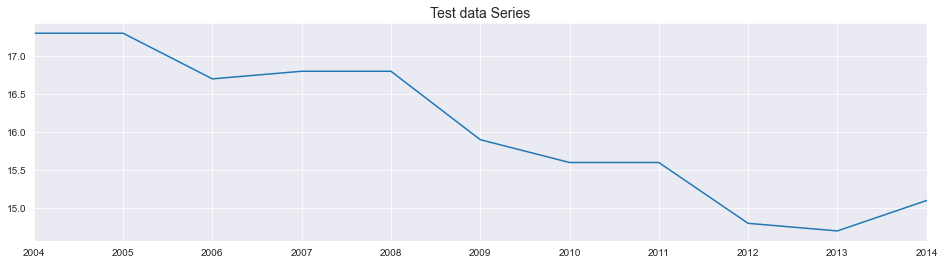

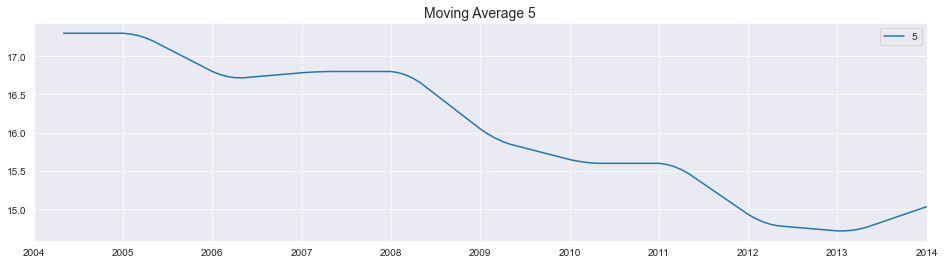

In [15]:
plt.figure(figsize=(16,4))
test_data.CO2.plot(label="org")
plt.title("Test data Series", fontsize=14)
plt.figure(figsize=(16,4))
test_data["CO2"].rolling(5).mean().plot(label=str(5))
plt.title("Moving Average "+str(5), fontsize=14)
plt.legend(loc='best')
plt.show()

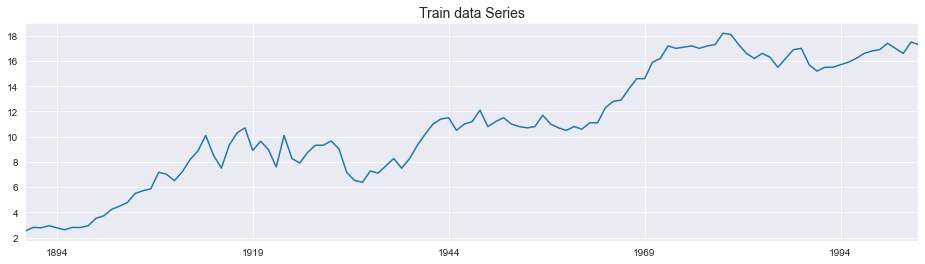

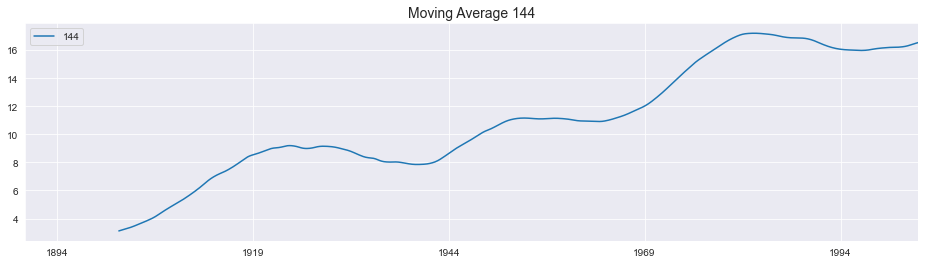

In [16]:
plt.figure(figsize=(16,4))
train_data.CO2.plot(label="org")
plt.title("Train data Series", fontsize=14)
plt.figure(figsize=(16,4))
train_data["CO2"].rolling(144).mean().plot(label=str(144))
plt.title("Moving Average "+str(144), fontsize=14)
plt.legend(loc='best')
plt.show()

### Evaluation Metric MAPE

In [72]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Model Building

___
## Exponential Methods
### Simple Exponential Method

#### Using Forecast Attribute

In [73]:
ses_model = SimpleExpSmoothing(train_data['CO2']).fit(optimized=True)
test_pred_ses = ses_model.forecast(121)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.CO2))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 8.282825400465304 
 Train Root Mean Squared Error = 0.061309007563282614 
 Test Root Mean Squared Error = 1.5528144715330983


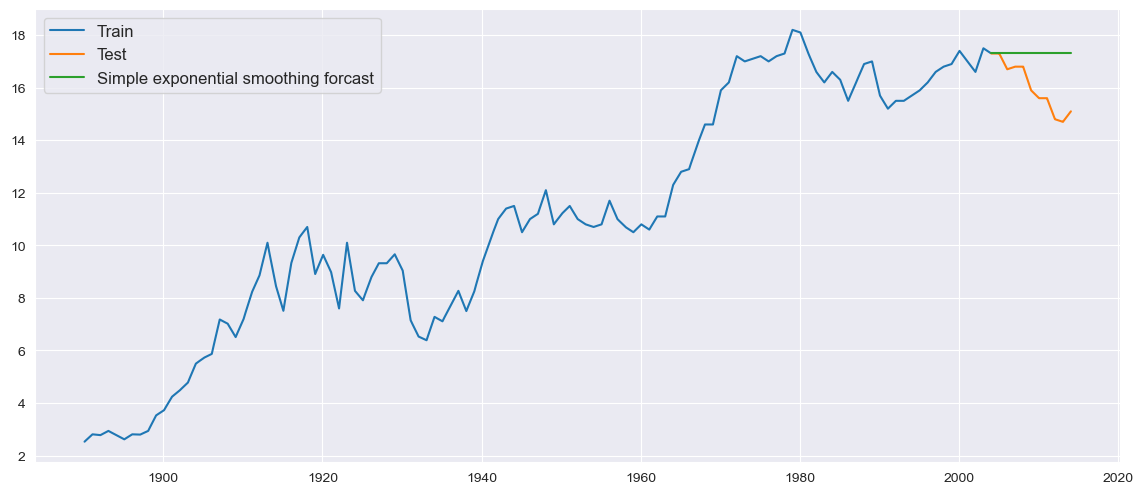

In [20]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. **This method doesn't captures seasonality.**

---
### Holt method (Double Exponential) 

##### Captures both Level and Trend .

In [74]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(121)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.CO2))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.CO2)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 2.2339855911113218 
 Train Root Mean Squared Error = 0.02533747225554109 
 Test Root Mean Squared Error = 0.43258040118492047


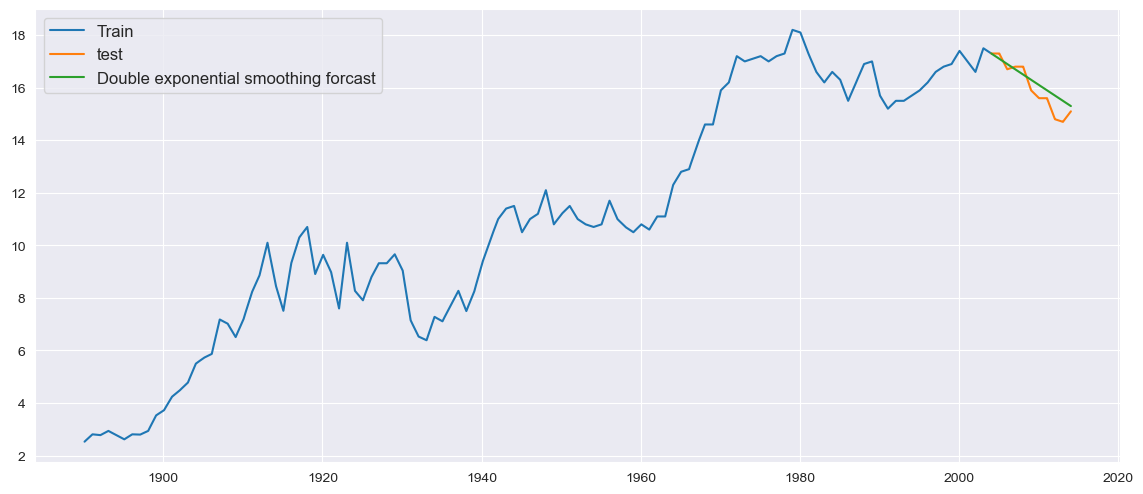

In [23]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that we are able to capture the trend of the data.
2. We were not able to capture the seasonality.

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

##### Captures Level, Trend and Seasonality.

In [75]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(121)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.CO2))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.CO2)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 2.197885047910496 
 Train Root Mean Squared Error = 0.025337286294858364 
 Test Root Mean Squared Error = 0.4249894511294967


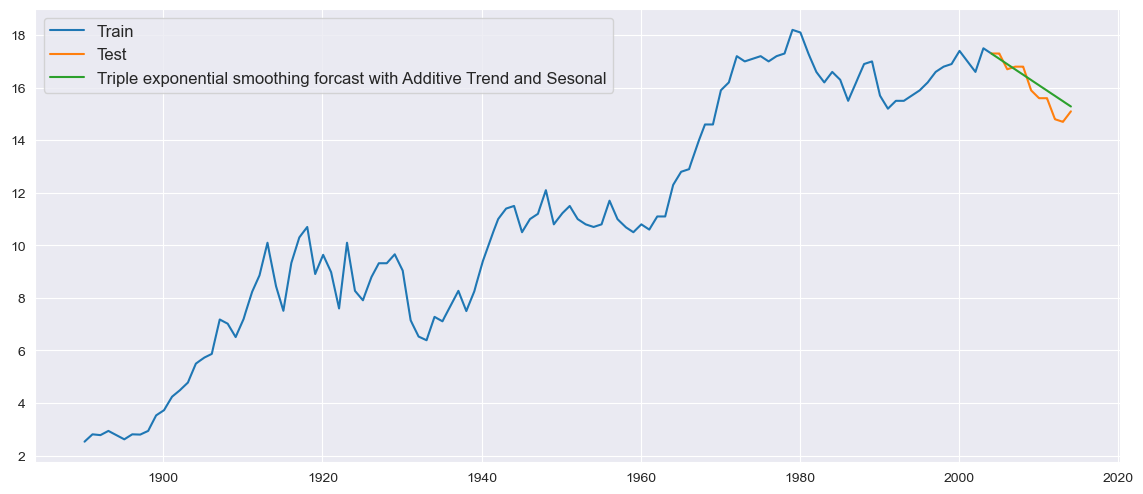

In [25]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. It captures the trend, but which we can see that the forecasted values are higher level than the test level.
2. It doesn't captures the seasonality.

### Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [76]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(121)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.CO2))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.CO2)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 1.7079488056459933 
 Train Root Mean Squared Error = 0.025315460762001182 
 Test Root Mean Squared Error = 0.326677659185395


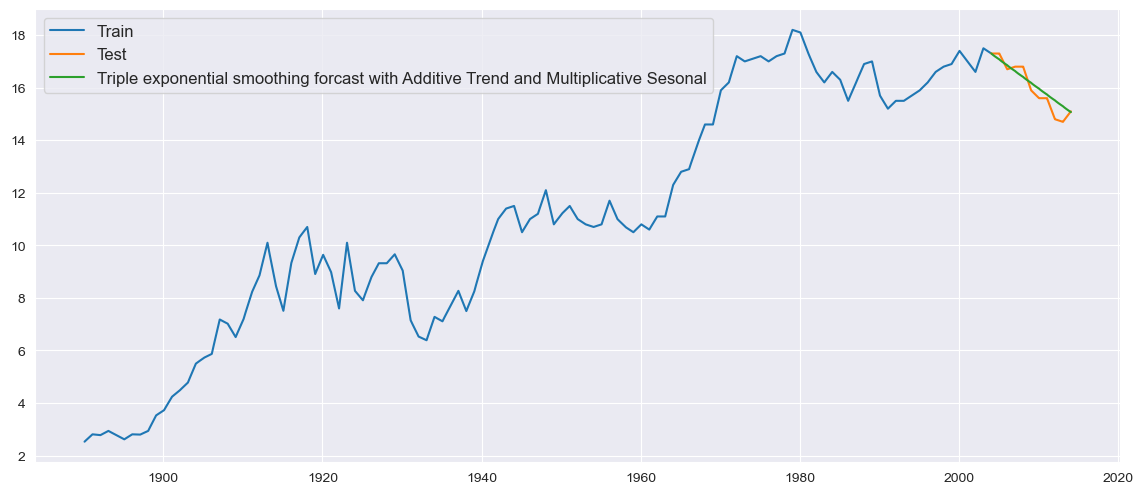

In [27]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best', fontsize=12)
plt.show()

#### Observation
1. We can see that the errors have not reduced, we are not able to capture the seasonality.

### Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [77]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(121)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.CO2))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.CO2)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 2.309308138427541 
 Train Root Mean Squared Error = 0.02536081652649869 
 Test Root Mean Squared Error = 0.4476653029642656


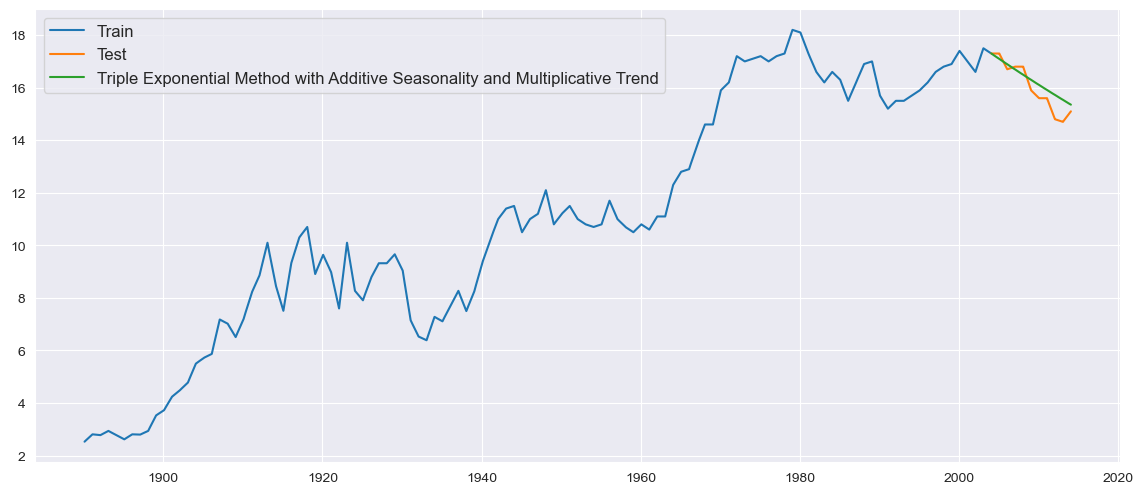

In [29]:
plt.figure(figsize=(14,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best', fontsize=12)
plt.show()

### Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [78]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(121)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.CO2))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.CO2)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 1.9174645560177723 
 Train Root Mean Squared Error = 0.0253350124708047 
 Test Root Mean Squared Error = 0.3666032939654663


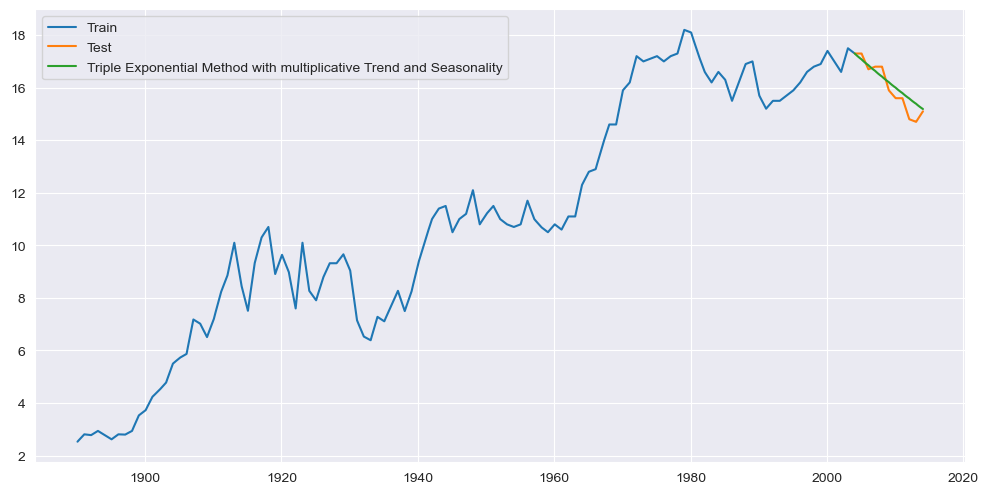

In [31]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

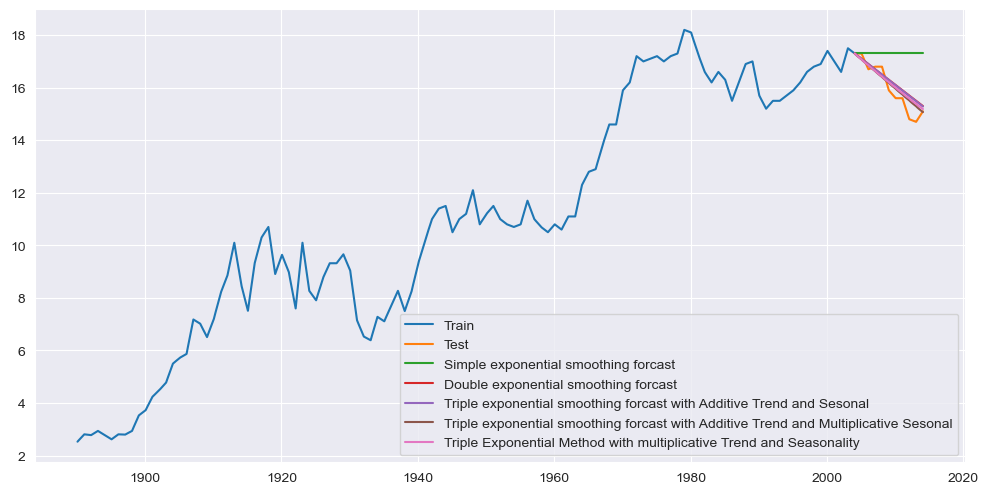

In [32]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

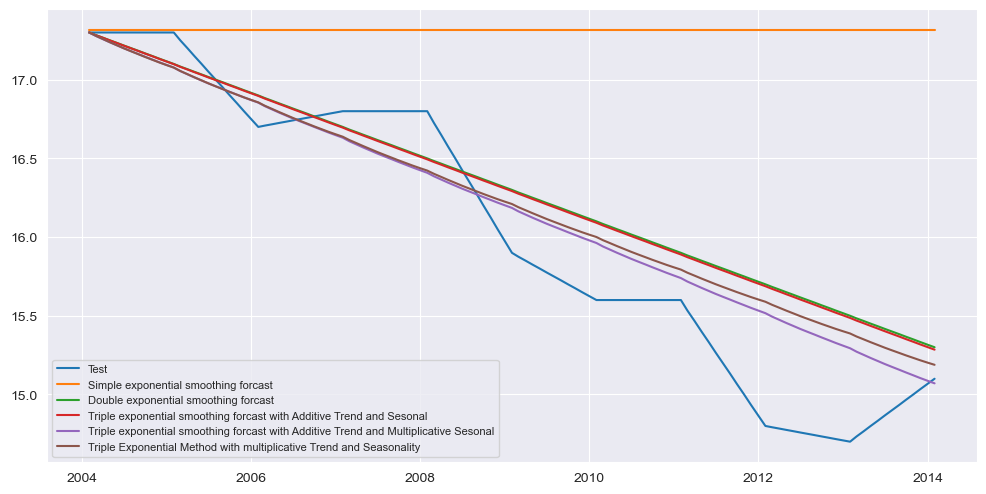

In [33]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best', fontsize=8)
plt.show()

In [79]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  Triple_Exp_mul_ad    0.025315      1.707949          0.326678
1     Triple_Exp_mul    0.025335      1.917465          0.366603
2      Triple_Exp_ad    0.025337      2.197885          0.424989
3         Double_Exp    0.025337      2.233986          0.432580
4  Triple_Exp_ad_mul    0.025361      2.309308          0.447665
5         Simple_Exp    0.061309      8.282825          1.552814

### Visualizing Models Performance

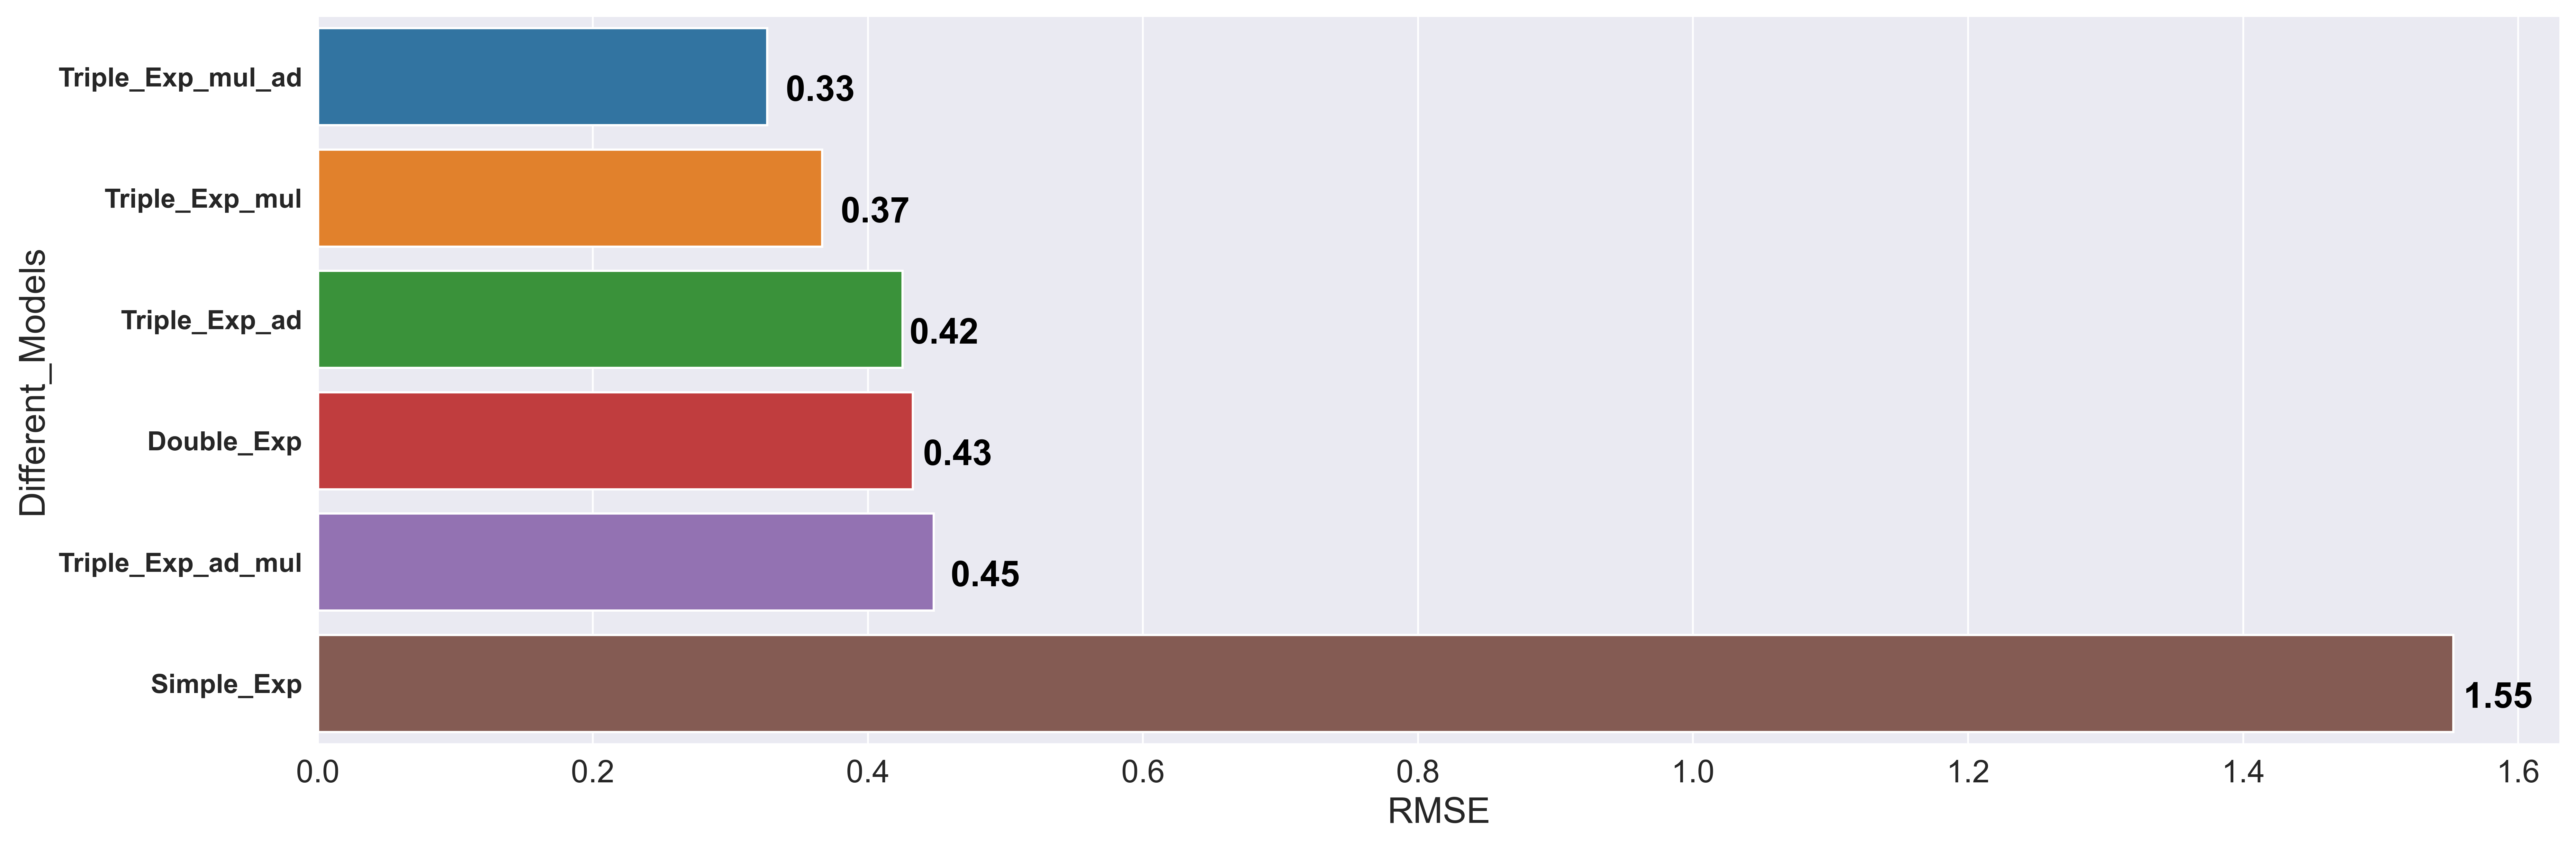

In [35]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('RMSE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,2)):
    axe.text(v + 0.01, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

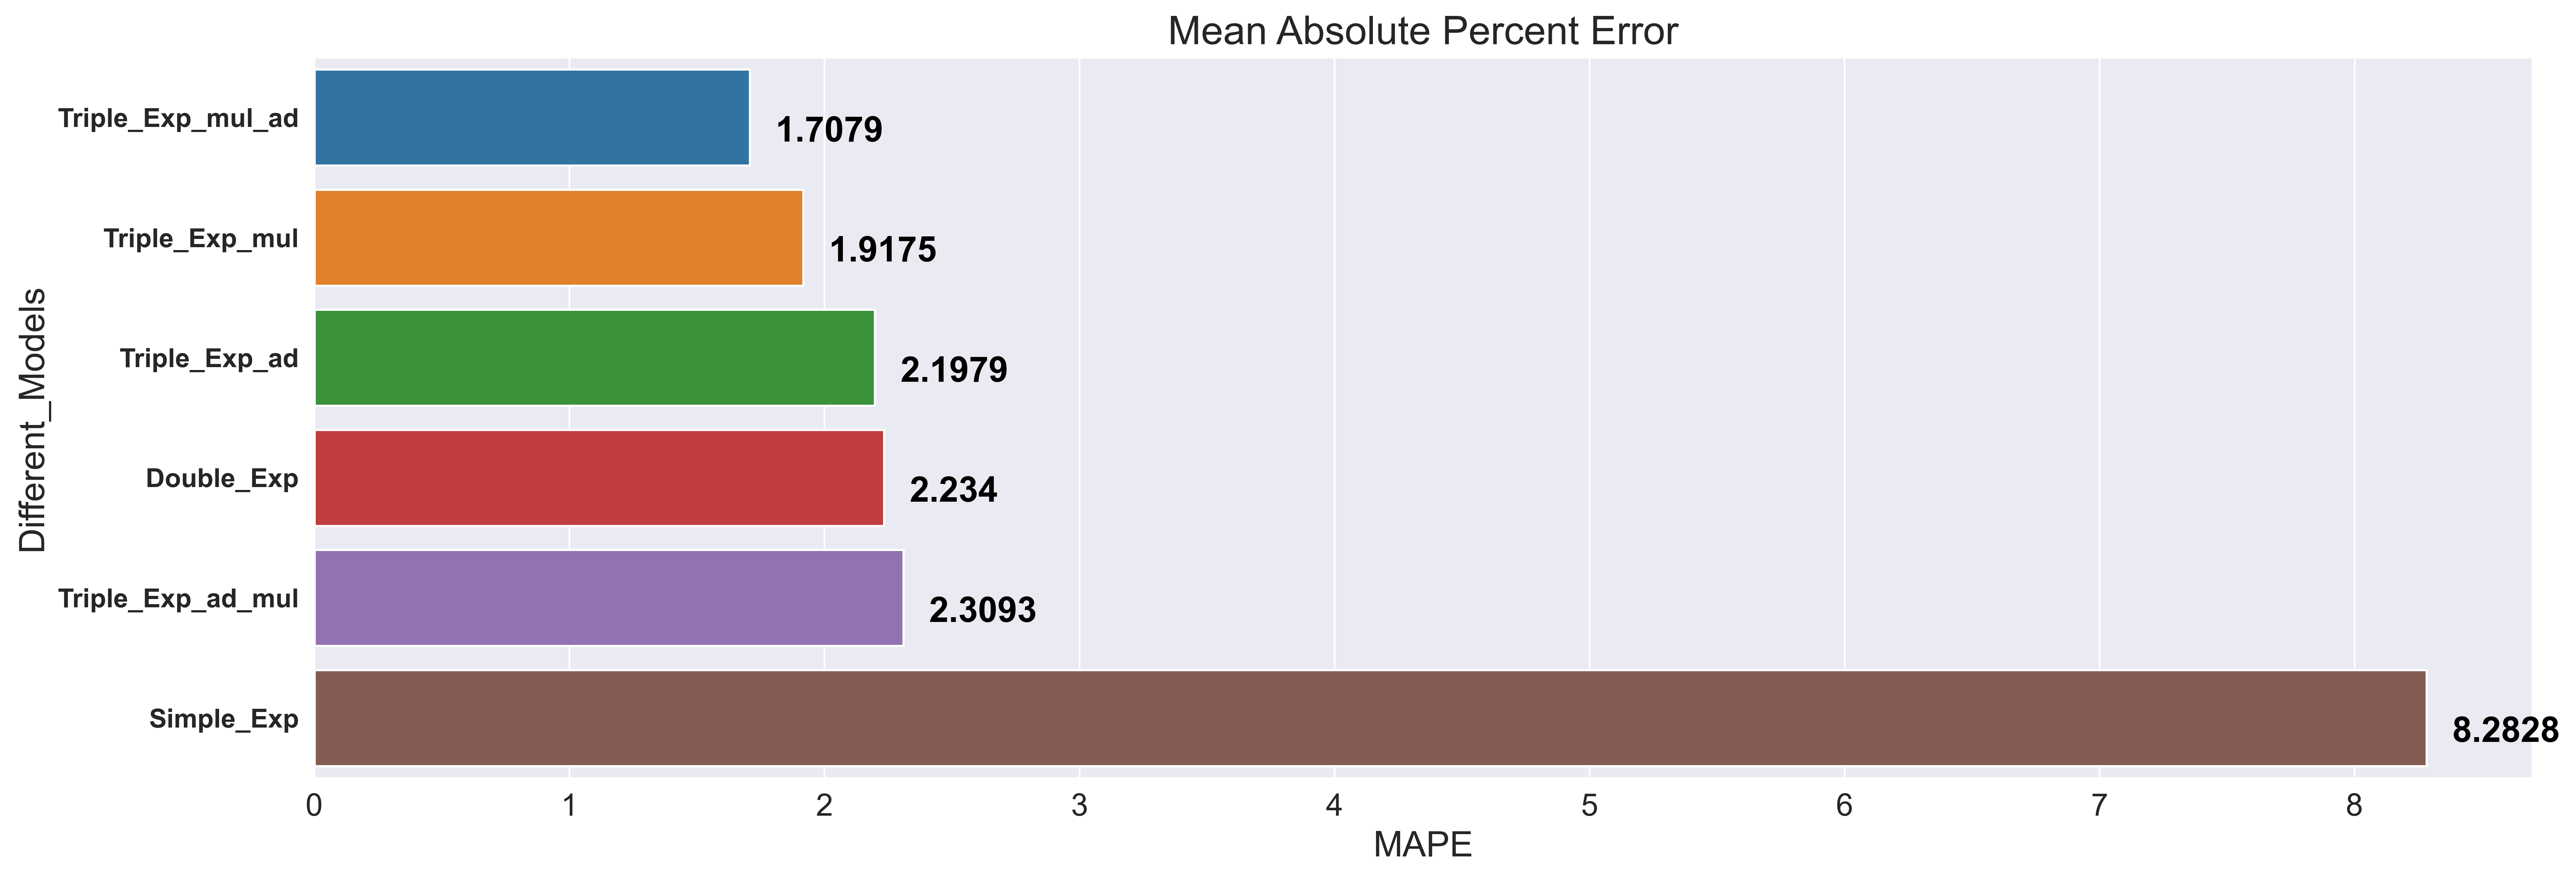

In [36]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Absolute Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['Test_MAPE(%)'].values,4)):
    axe.text(v + 0.1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

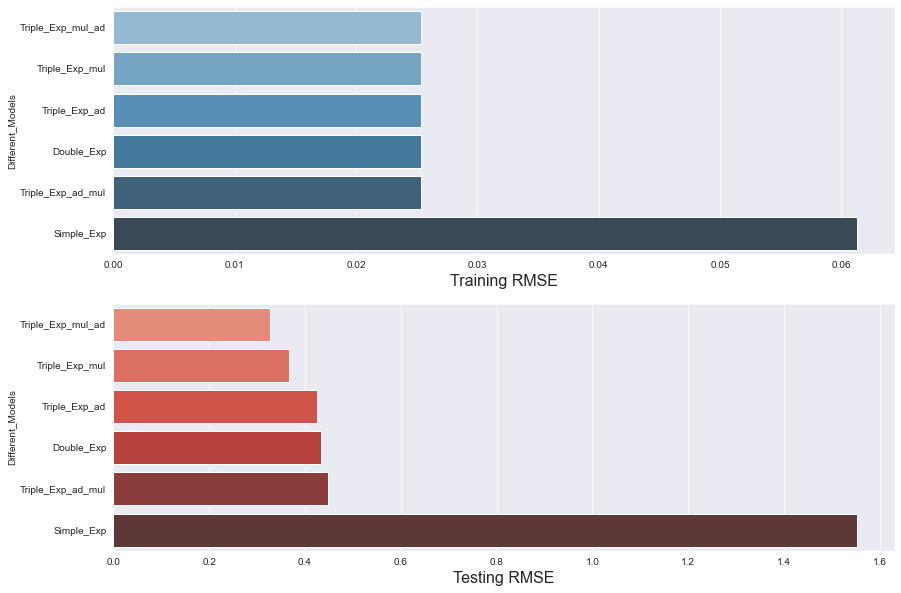

In [37]:
f, axes = plt.subplots(2,1, figsize=(14,10))
train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=True)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models')

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=True)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models')

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

Recall that an <strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

### Assumptions of ARIMA model
1. **Data should be stationary** – by stationary it means that the properties of the series doesn’t depend on the time when it is captured. A white noise series and series with cyclic behavior can also be considered as stationary series.
2. **Data should be univariate** – ARIMA works on a single variable. Auto-regression is all about regression with the past values.

#### Stationary vs Non-stationary Time Series

## ARIMA Hyperparameter Tuning

***order(p,d,q)***

p = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series.

d = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary.


q = This variable denotes the lag of the error component, where error component is a part of the time series not explained by trend or seasonality.

In [6]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [39]:
import itertools

In [40]:
p = range(0,8)
q = range(0,8)
d = range(0,5)

In [41]:
pqd_combination = list(itertools.product(p,d,q))

In [42]:
len(pqd_combination)

320

In [43]:
rmse = []
order = []

In [44]:
for pdq in pqd_combination:
    try:
        model = ARIMA(train_data, order=pdq).fit()
        pred = model.forecast(121)
        error = np.sqrt(mean_squared_error(test_data,pred))
        order.append(pdq)
        rmse.append(error)
    except:
        continue

In [45]:
value_pqd = pd.DataFrame(index=order,data=rmse,columns=['rmse'])
value_pqd.sort_values('rmse')

rmse
(5, 3, 1)   0.213950
(6, 3, 1)   0.214035
(5, 3, 3)   0.215606
(0, 4, 2)   0.216273
(7, 4, 3)   0.217360
...              ...
(5, 4, 4)  17.789760
(7, 4, 4)  18.633440
(3, 4, 7)  26.053994
(0, 4, 5)  44.520535
(3, 4, 2)  53.665876

[320 rows x 1 columns]

In [46]:
results = pd.DataFrame(index=order,data=rmse,columns=['RMSE'])
results.sort_values('RMSE')

RMSE
(5, 3, 1)   0.213950
(6, 3, 1)   0.214035
(5, 3, 3)   0.215606
(0, 4, 2)   0.216273
(7, 4, 3)   0.217360
...              ...
(5, 4, 4)  17.789760
(7, 4, 4)  18.633440
(3, 4, 7)  26.053994
(0, 4, 5)  44.520535
(3, 4, 2)  53.665876

[320 rows x 1 columns]

In [49]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [50]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

### ARIMA Hyperparameter Tuning using Original Time series.

In [ ]:
# evaluate parameters
p_values = range(0, 8)
d_values = range(0, 5)
q_values = range(0, 8)
evaluate_models(train_data.values, test_data.values, p_values, d_values, q_values)

### ^Observation: After using Resampled dataset we got the best optimal values

In [56]:
arima_model = ARIMA(train_data, order=(5, 3, 1))
arima_model_fit = arima_model.fit()
y_hat_ar = df.copy()
y_hat_ar['arima_forecast'] = arima_model_fit.predict(start = df.index.min(), end = df.index.max())

In [57]:
%matplotlib inline

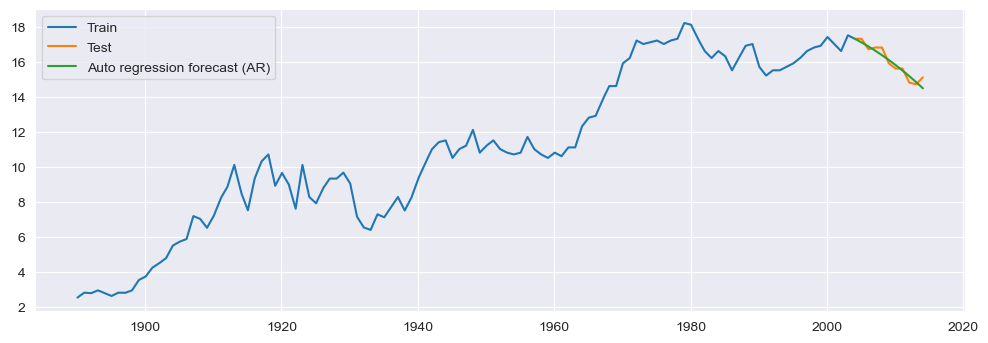

In [58]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

#### Observation
1. We can see that we have done moderately well.
2. No Seasonality captured. Only Trend has been captured

### Model Evaluation

### Training Error

In [59]:
train_arima  = arima_model_fit.fittedvalues
train_rmse_arima  = sqrt(mean_squared_error(train_arima ,train_data))
train_rmse_arima

0.10020477990789405

### Testing Error

#### RMSE (Root Mean Squared Error)

In [60]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(3)
rmse_ARIMA

0.214

#### MAPE (Mean Absolute Percent Error)

In [61]:
mape_arima = round(np.mean(np.abs((test_data.CO2 - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.CO2)*100),3)
mape_arima

1.097

#### Observation
1. We can see that AR model has done reasonably good job but not better than Holt's method.
2. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

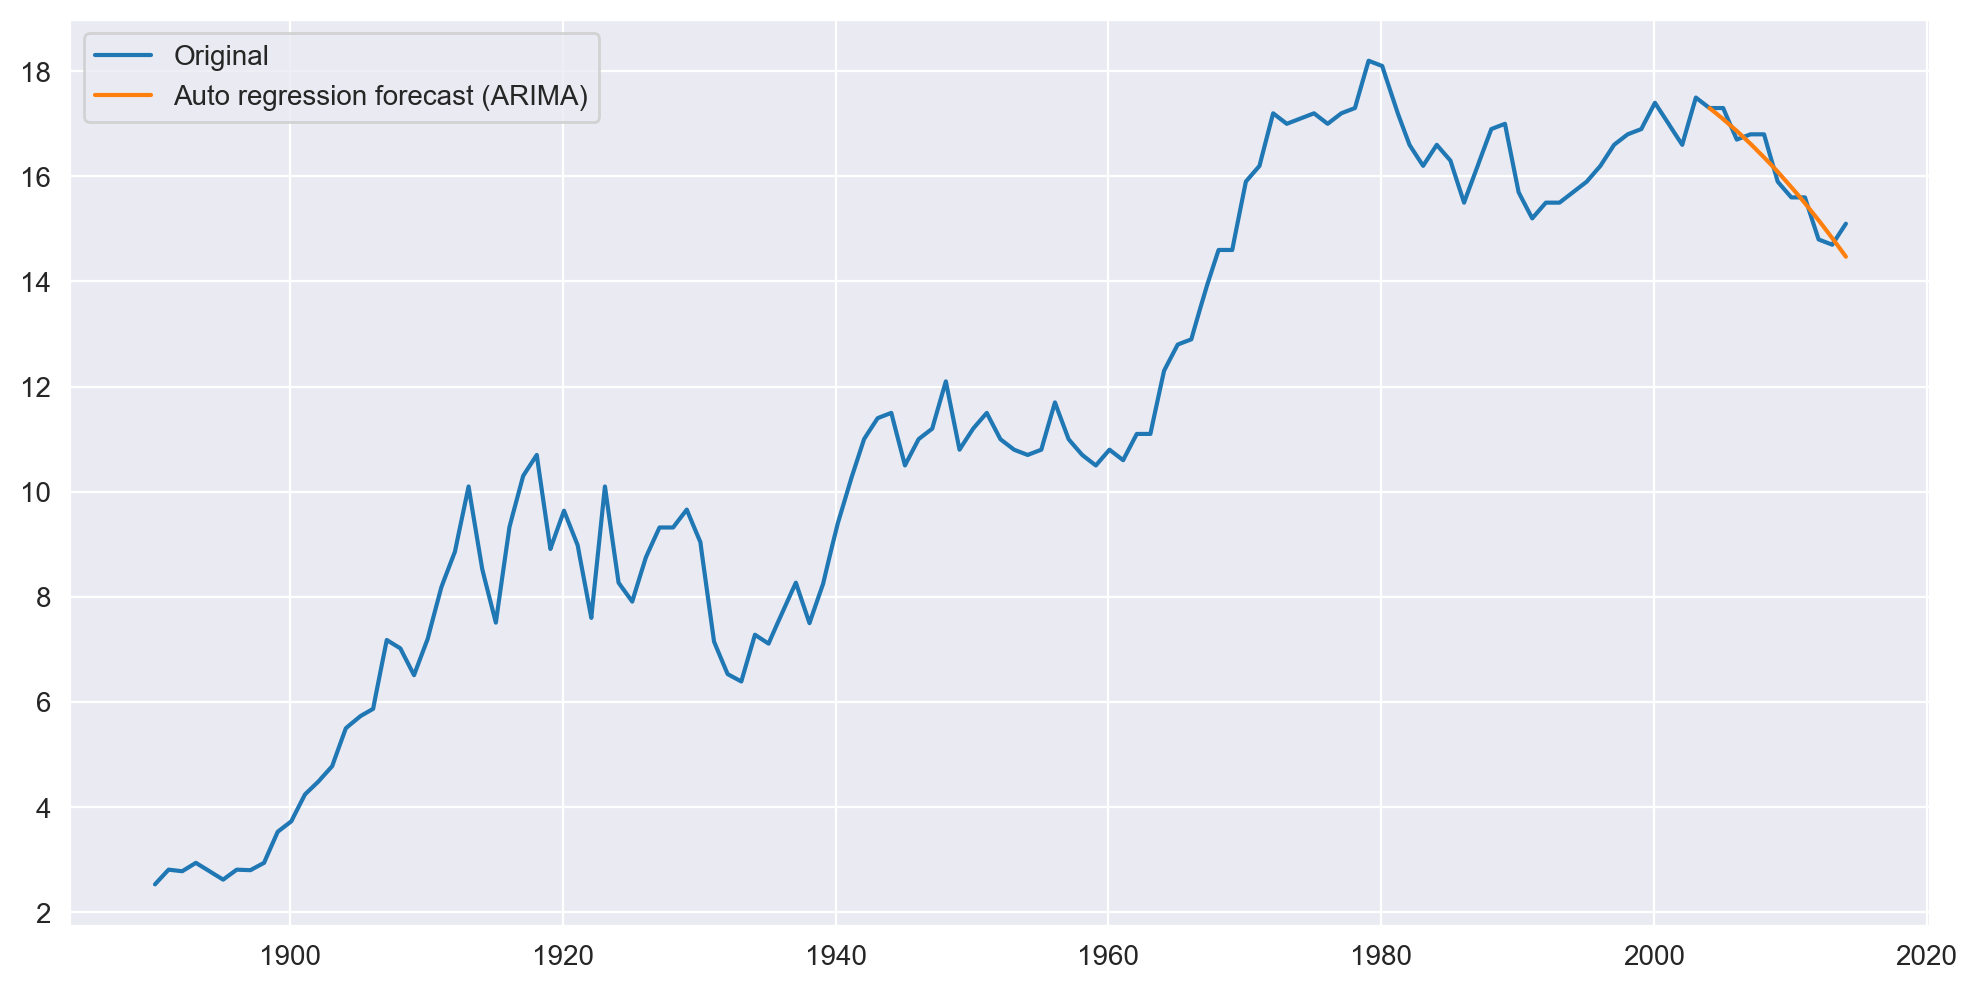

In [51]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(df['CO2'], label='Original')
plt.plot(y_hat_ar['arima_forecast'], label='Auto regression forecast (ARIMA)')
plt.legend(loc='best')
plt.show()

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [52]:
model_residual = arima_model_fit.resid
model_residual.mean()

0.00032965820135481914

#### Residuals must be stationary

In [20]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [21]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

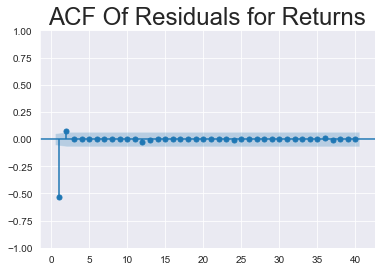

In [22]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

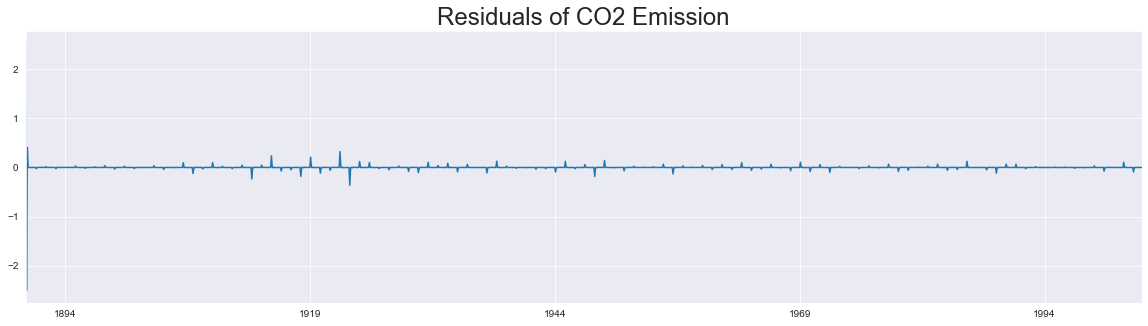

In [23]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of CO2 Emission", size=24)
plt.show()

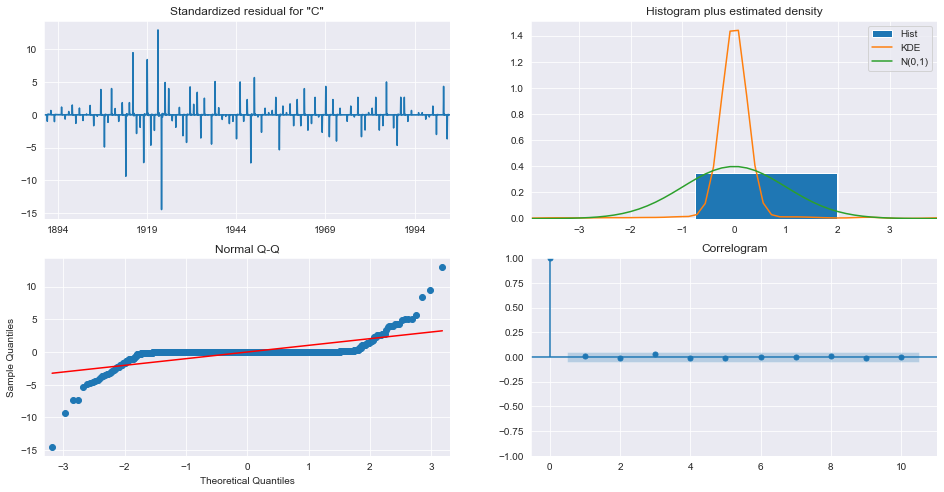

In [25]:
arima_model_fit.plot_diagnostics(figsize=(16,8))
plt.show()

In [53]:
y_hat_ar[test_data.index.min():]

CO2  arima_forecast
2004-01-31  17.300000       17.299887
2004-02-29  17.300000       17.282994
2004-03-31  17.300000       17.265988
2004-04-30  17.300000       17.248873
2004-05-31  17.300000       17.231645
...               ...             ...
2013-09-30  14.966667       14.591374
2013-10-31  15.000000       14.561454
2013-11-30  15.033333       14.531421
2013-12-31  15.066667       14.501276
2014-01-31  15.100000       14.471019

[121 rows x 2 columns]

In [62]:
y_hat_ar

CO2  arima_forecast
1890-01-31   2.530000        0.000000
1890-02-28   2.553333        5.060000
1890-03-31   2.576667        2.166667
1890-04-30   2.600000        2.600000
1890-05-31   2.623333        2.623333
...               ...             ...
2013-09-30  14.966667       14.591374
2013-10-31  15.000000       14.561454
2013-11-30  15.033333       14.531421
2013-12-31  15.066667       14.501276
2014-01-31  15.100000       14.471019

[1489 rows x 2 columns]

In [63]:
np.mean(APE.tail(20))

1.7070405807234406

### Calculating Absolute Percent Error and Error<a class="anchor" id="7.3"></a>

In [64]:
# Computing the absolute percent error
APE=100*(abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast'])/y_hat_ar['CO2'])
Error = (abs(y_hat_ar['CO2']-y_hat_ar['arima_forecast']))
print('The Accuracy for Test Data -- ARIMA model = {}%'.format(np.round(100-np.mean(APE.tail(20))),2))
print('The Mean Error for Test Data -- ARIMA model = ', np.mean((Error.tail(20))))

# adding absolute percent error to table
y_hat_ar['Error']=Error
y_hat_ar['Absolute Percent Error %']=APE

y_hat_ar.tail(121)

The Accuracy for Test Data -- ARIMA model = 98.0%
The Mean Error for Test Data -- ARIMA model =  0.25456510078860256


CO2  arima_forecast     Error  Absolute Percent Error %
2004-01-31  17.300000       17.299887  0.000113                  0.000656
2004-02-29  17.300000       17.282994  0.017006                  0.098300
2004-03-31  17.300000       17.265988  0.034012                  0.196599
2004-04-30  17.300000       17.248873  0.051127                  0.295535
2004-05-31  17.300000       17.231645  0.068355                  0.395115
...               ...             ...       ...                       ...
2013-09-30  14.966667       14.591374  0.375292                  2.507522
2013-10-31  15.000000       14.561454  0.438546                  2.923640
2013-11-30  15.033333       14.531421  0.501912                  3.338661
2013-12-31  15.066667       14.501276  0.565390                  3.752591
2014-01-31  15.100000       14.471019  0.628981                  4.165437

[121 rows x 4 columns]

[Table of Contents](#0.1)

### 7.4 Visualizing the Relationship between the Actual and Predicted ValuesModel Validation<a class="anchor" id="7.4"></a>

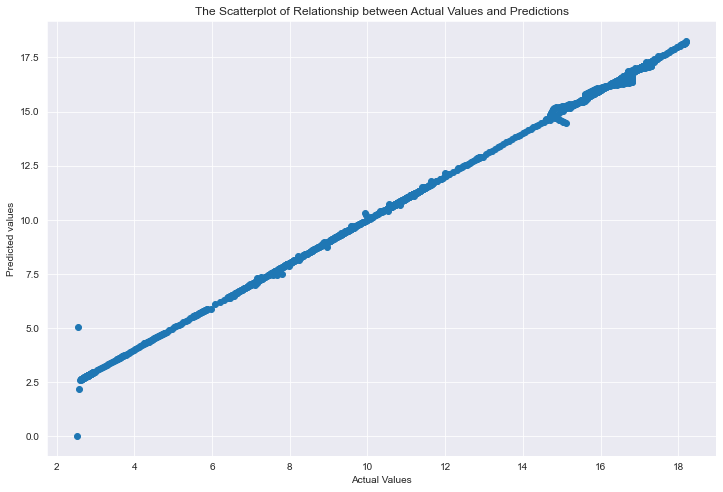

In [65]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(y_hat_ar['CO2'], y_hat_ar['arima_forecast'])

In [48]:
y_hat_ar.to_csv('C:/Users\Moin Dalvi\Documents\Data Science Material\Projects\Air Quality Forecasting/prediction.csv')

### Seasonal Auto Regressive Integrated Moving Average (SARIMA)
ARIMA with Seasonal component added.

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# We are only passing the Box Cox because the ARIMAX will perform the differencing internally
# seasonal_order P=1, Q=1, D=1 and m=12
# m=12 . Because the seasonality is monthly.

In [81]:
sarima_model = SARIMAX(train_data, order=(5, 3, 1), seasonal_order=(5, 3, 1,12))
sarima_model_fit= sarima_model.fit()


#### Inverse Transformation of the Differencing Box-Cox Transformation
Note that ARIMAM automatically takes care of the reversing of `Differencing` (takes care the `Integration` part automatically). So, we don't need to perform the cumsum here. We only have to do the reverse of the log boc cox transformation.

In ARIMA, we had to perform the cumsum manually.

In [83]:
y_hat_sarima = df.copy()
y_hat_sarima['sarima_forecast'] = sarima_model_fit.predict(df.index.min(), df.index.max())

In [84]:
y_hat_sarima

CO2  sarima_forecast
1890-01-31   2.530000         0.000000
1890-02-28   2.553333         6.325000
1890-03-31   2.576667         1.362051
1890-04-30   2.600000         2.600000
1890-05-31   2.623333         2.623333
...               ...              ...
2013-09-30  14.966667        48.261939
2013-10-31  15.000000        48.819775
2013-11-30  15.033333        49.372403
2013-12-31  15.066667        49.919823
2014-01-31  15.100000        50.460788

[1489 rows x 2 columns]

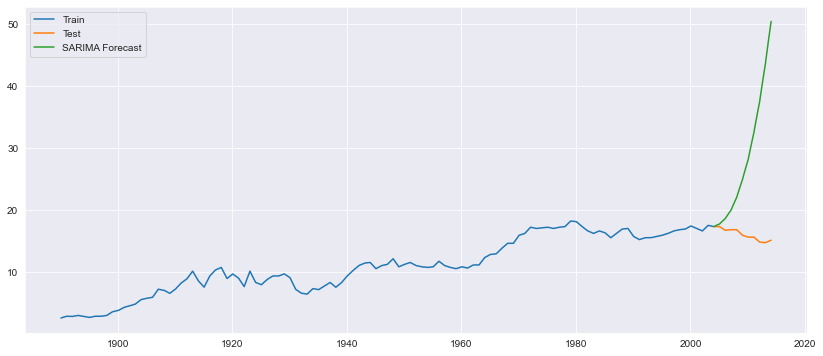

In [85]:
plt.figure(figsize=(14,6))
plt.plot(train_data['CO2'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

##### We can see that we are able to capture the trend and seasonality both.

### Model Evaluation

### Training Error

In [90]:
train_sarima  = sarima_model_fit.fittedvalues
train_rmse_sarima  = sqrt(mean_squared_error(train_sarima ,train_data))
train_rmse_sarima

0.1470552796772549

### Testing Error

#### RMSE (Root Mean Squared Error)

In [91]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

15.99

#### MAPE (Mean Absolute Percent Error)

In [92]:
mape_sarima = round(np.mean(np.abs((test_data.CO2 - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.CO2)*100),2)
mape_sarima

78.14

#### Observation:
1. SARIMA method has done reasonably well as it captures seasonality.
2. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality. |

### Analysing the Residuals

##### The mean of the Residual should be zero or close to Zero

In [93]:
model_residual = sarima_model_fit.resid
model_residual.mean()

0.0006562114270198936

#### Residuals must be stationary

In [94]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

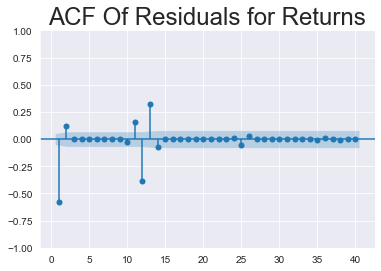

In [95]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

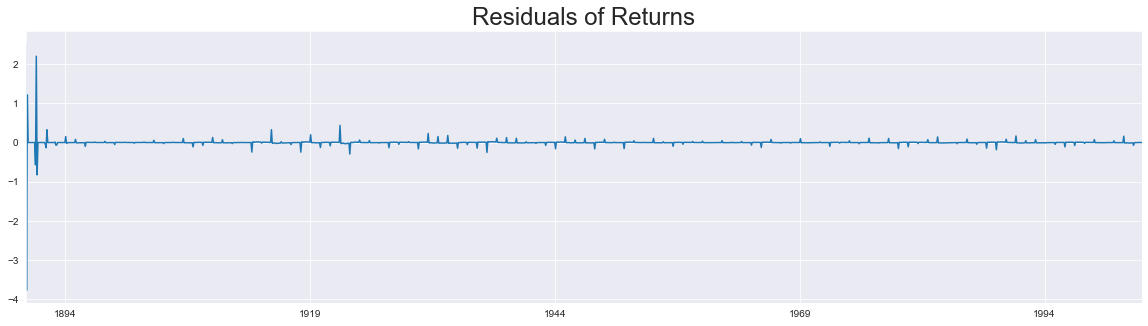

In [96]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

#### Creating model with differente Transformation Technique

In [97]:
#Compareing the results 

Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_additive","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_multiplicative","ARIMA","SARIMA"]),\
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_ARIMA,rmse_SARIMA])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models    MAPE(%)  RMSE_Values
0                      ARIMA   1.097000     0.214000
1          Triple_Exp_mul_ad   1.707949     0.326678
2  Triple_Exp_multiplicative   1.917465     0.366603
3        Triple_Exp_additive   2.197885     0.424989
4         Double_Exponential   2.233986     0.432580
5          Triple_Exp_ad_mul   2.309308     0.447665
6         Simple_Exponential   8.282825     1.552814
7                     SARIMA  78.140000    15.990000

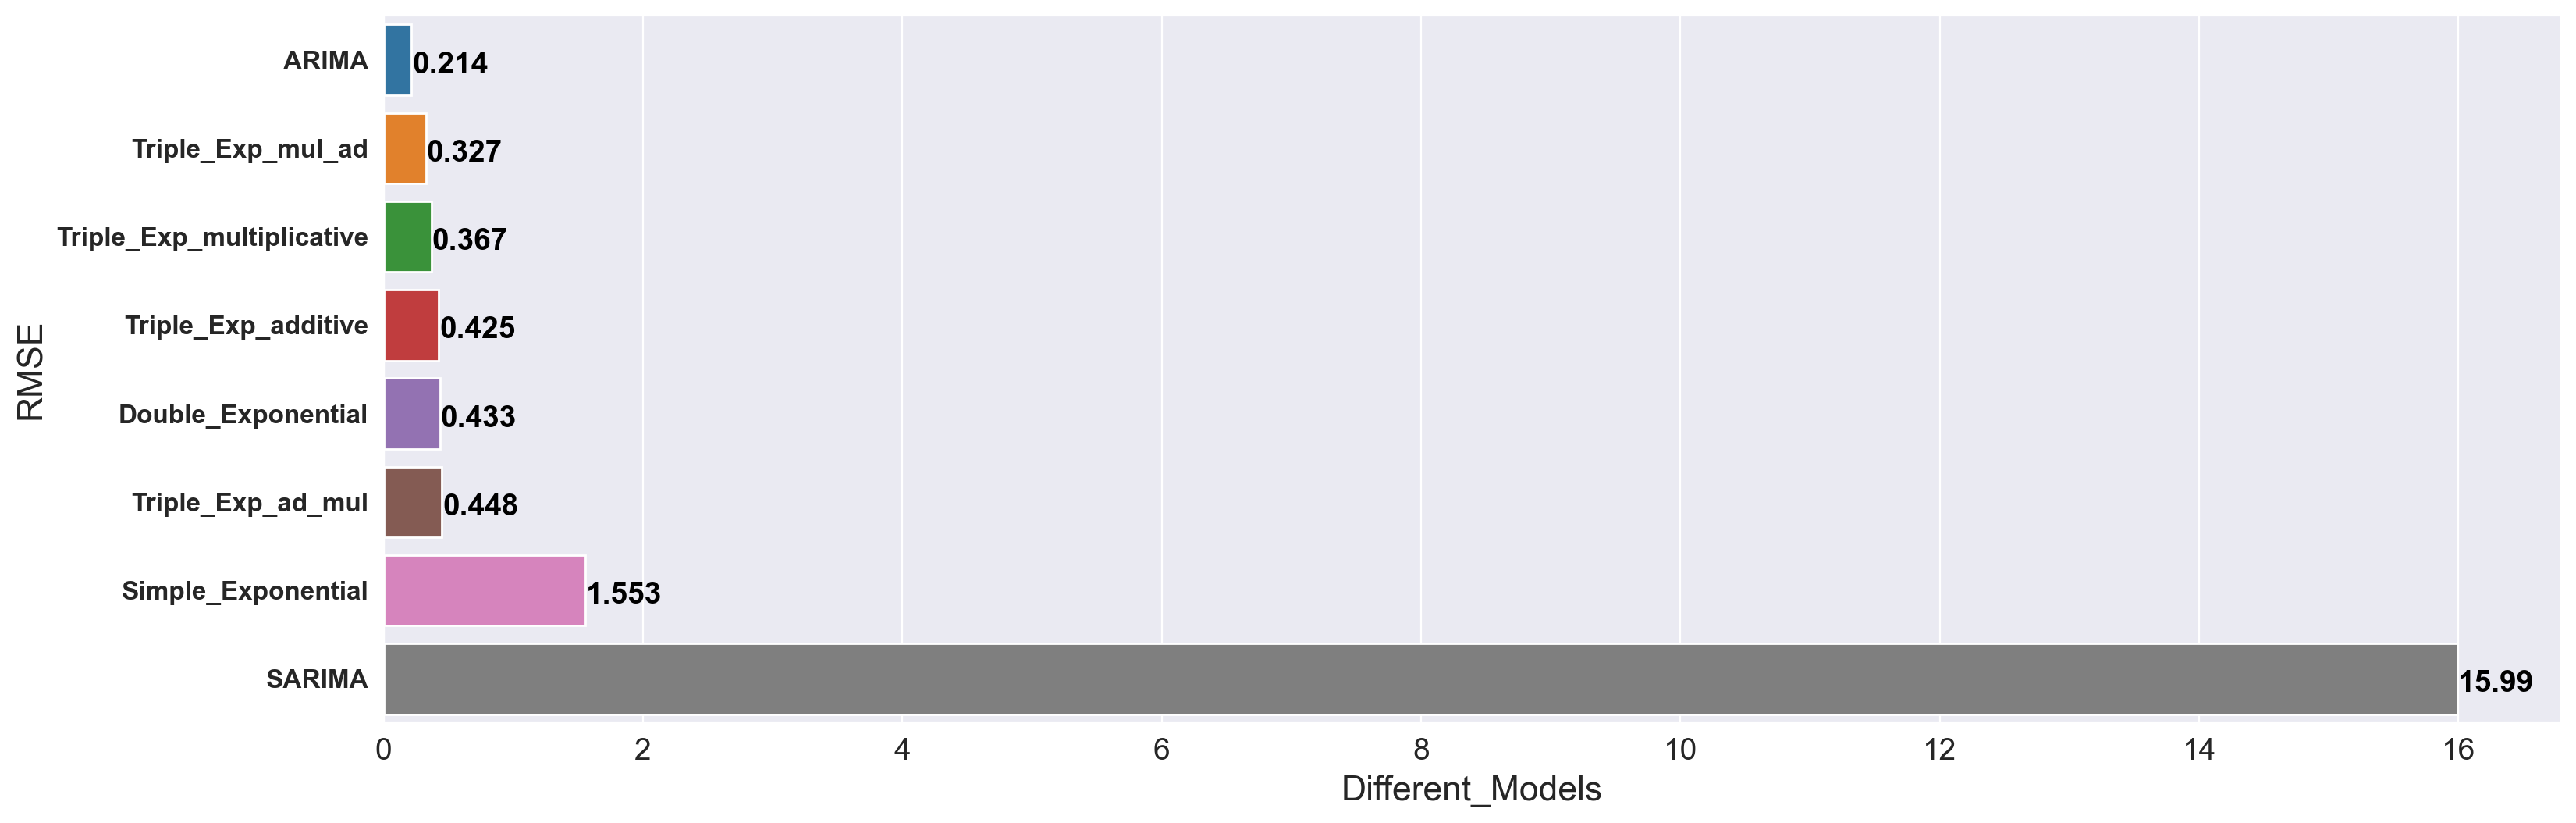

In [98]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,3)):
    axe.text(v + 0.005, i + .15, str(v),
            color = 'black', fontweight = 'bold', fontsize= 14)

plt.show()

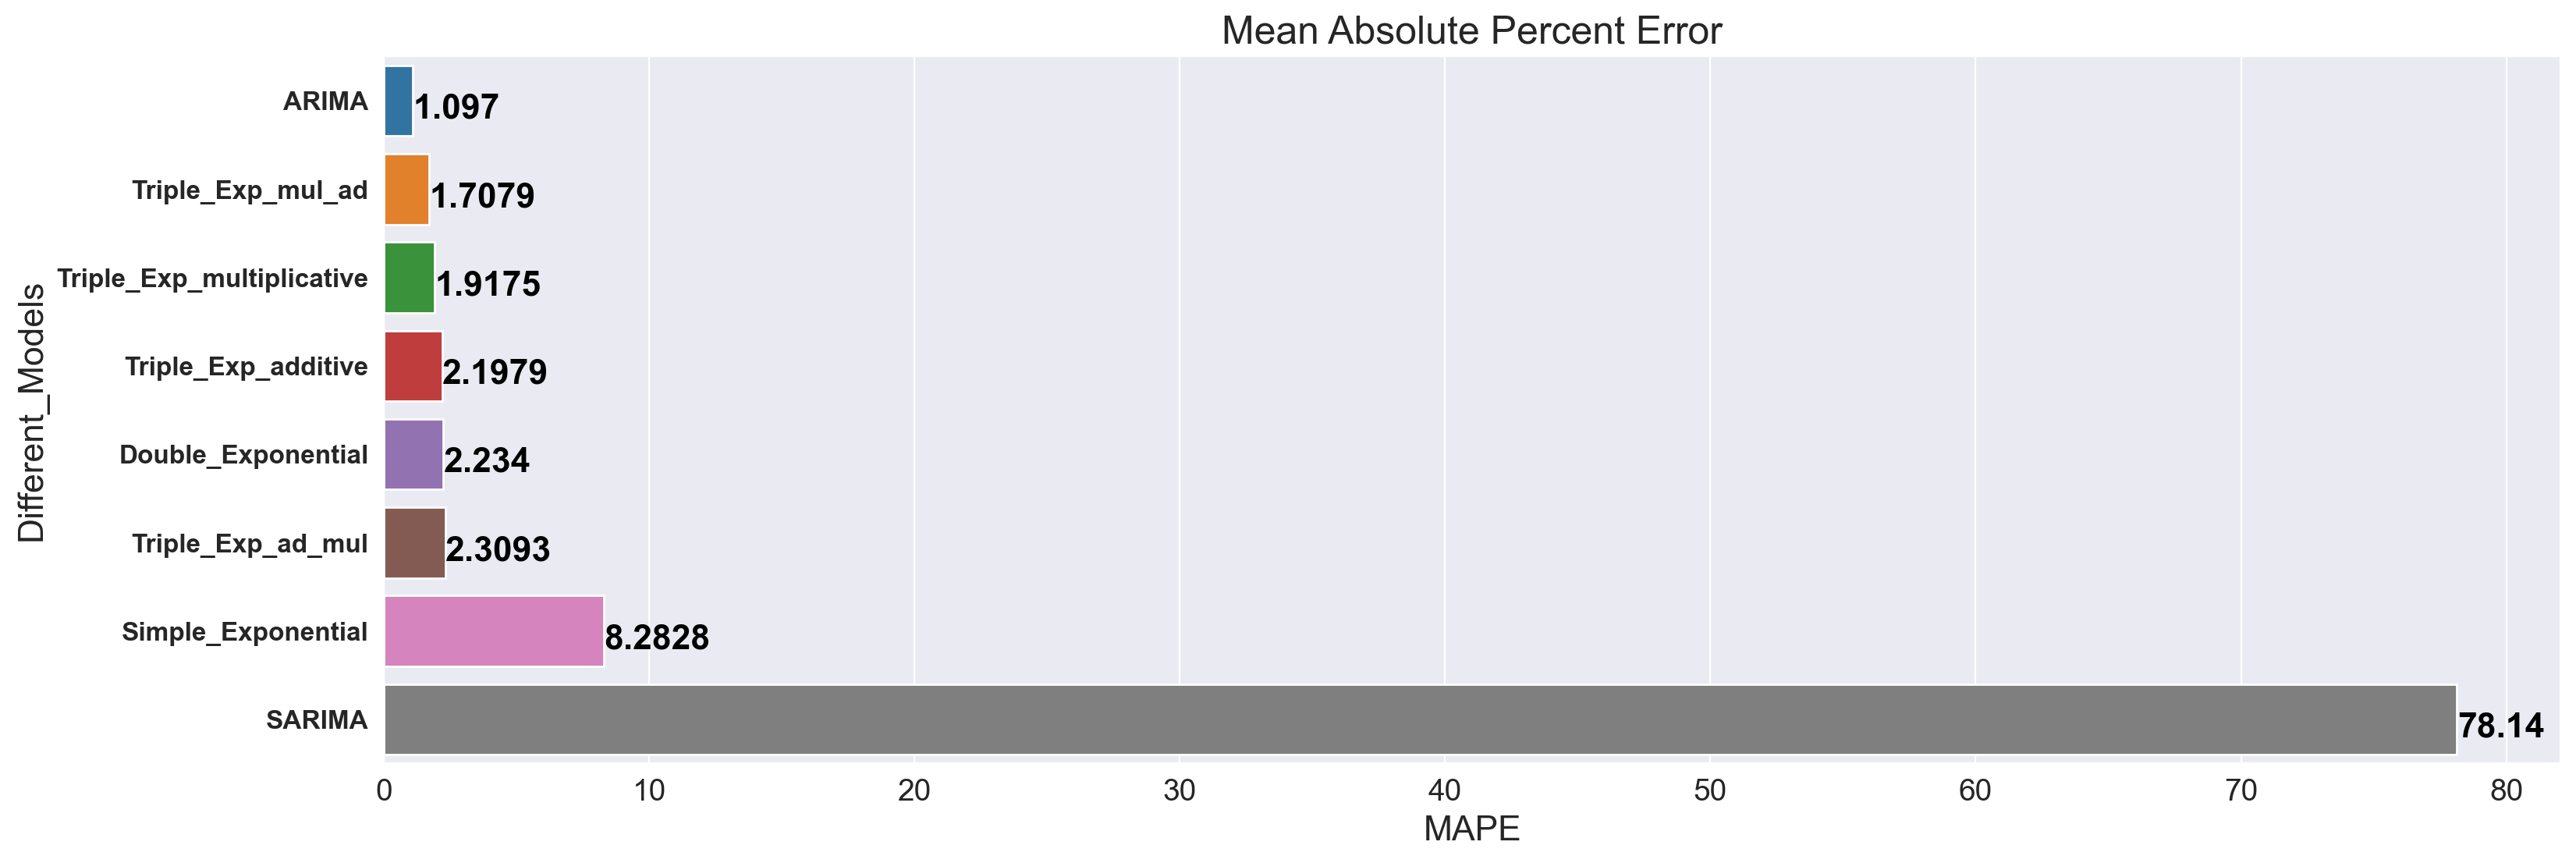

In [99]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=200)
sns.barplot(x='MAPE(%)', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Different_Models', size=16)
plt.title("Mean Absolute Percent Error", fontsize = 18)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation['MAPE(%)'].values,4)):
    axe.text(v + 0.01, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#### Observation:
+ **The Sarima Model did not performed very well as compared to other Models but Simple Exponential Smoothing better** 
+ **Note:Sarima with Hyperparameter tuning may get better results**
+ **Even in models such as ARIMA with hyperparameter tuning gave the best restult in this case**

#### Conclusion:
## <p style="color:black;font-size:18;">ARIMA:</p><p style="color:black;font-size:14px;">The best model we have got so far with the lowest RMSE and lowest MAPE.</p>    

### Forecasting Future Values Using ARIMA Model

#### Forecasting 5 years of data using the complete Data set

In [8]:
%matplotlib inline

In [69]:
df.shape

(1489, 1)

In [70]:
1489+60

1549

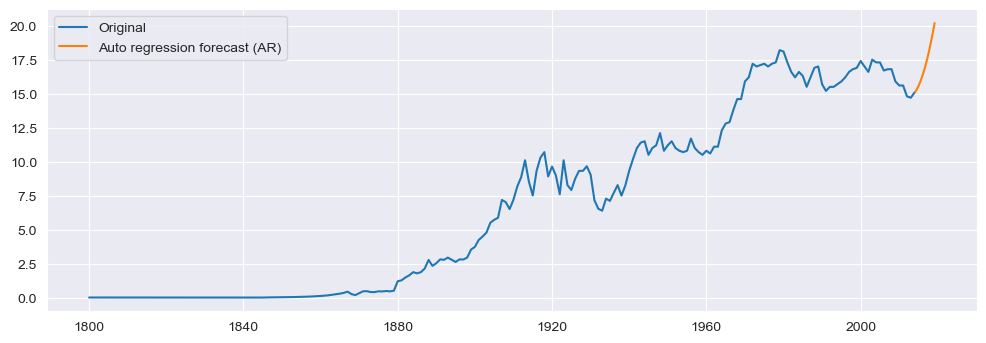

In [71]:
final_model = ARIMA(df, order=(5, 3, 1))
final_model_fit = final_model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_model_fit.predict(start = 1489, end = 1549)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

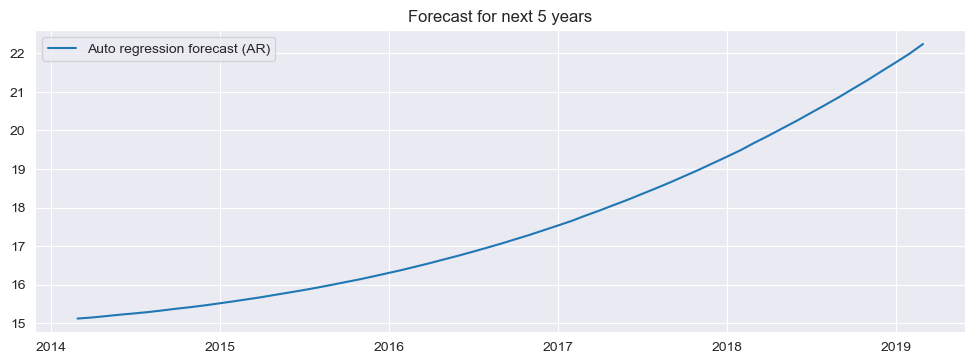

In [200]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 5 years')
plt.legend(loc='best')
plt.show()

In [204]:
forecast

arima_forecast
2014-02-28       15.124414
2014-03-31       15.151952
2014-04-30       15.186944
2014-05-31       15.225139
2014-06-30       15.257040
...                    ...
2018-10-31       21.304195
2018-11-30       21.530950
2018-12-31       21.762527
2019-01-31       21.999357
2019-02-28       22.241986

[61 rows x 1 columns]

In [203]:
2569+120

2689

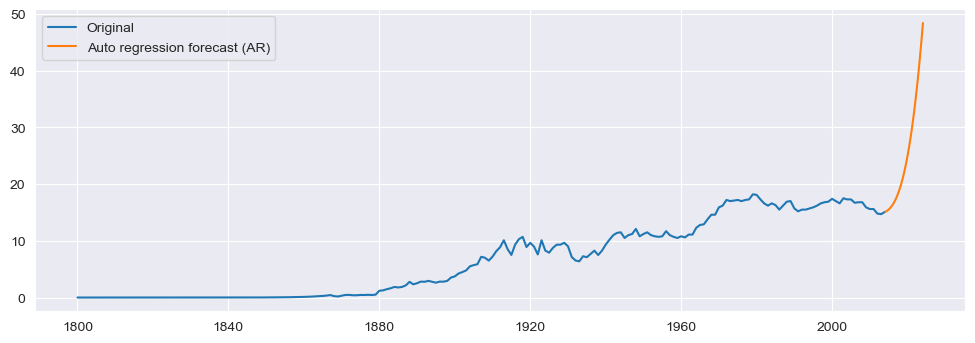

In [205]:
final_model = ARIMA(interpolated_month, order=(6, 4, 7))
final_model_fit = final_model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_model_fit.forecast(120)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['CO2'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

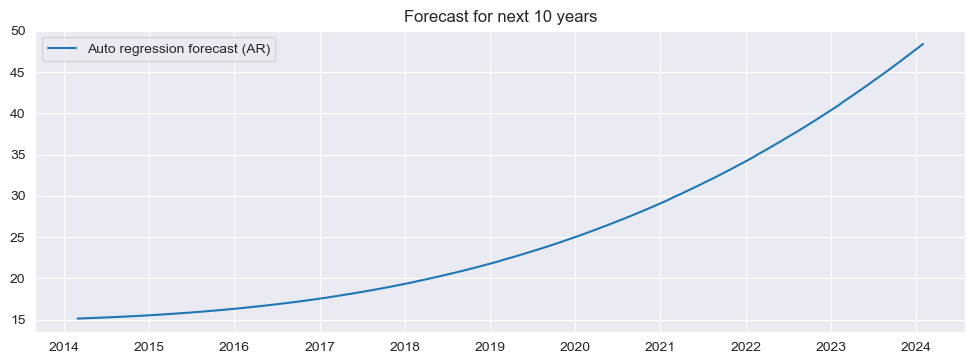

In [206]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 10 years')
plt.legend(loc='best')
plt.show()

In [207]:
forecast

arima_forecast
2014-02-28       15.124414
2014-03-31       15.151952
2014-04-30       15.186944
2014-05-31       15.225139
2014-06-30       15.257040
...                    ...
2023-09-30       45.750608
2023-10-31       46.396366
2023-11-30       47.051104
2023-12-31       47.714914
2024-01-31       48.387849

[120 rows x 1 columns]

## Links for the repositories

<div style="display:fill;
            border-radius: false;
            border-style: solid;
            border-color:#000000;
            border-style: false;
            border-width: 2px;
            color:#CF673A;
            font-size:15px;
            font-family: Georgia;
            background-color:#E8DCCC;
            text-align:center;
            letter-spacing:0.1px;
            padding: 0.1em;">

**<h2>♡ Thank you for taking the time ♡**